# **This part is the LLM part of the first notebook**

In [1]:
import pandas as pd
import transformers


## What about the LLMs?

**You must write the answer to this question in a notebook hosted in your github account and give access to your supervisor.**

LLMs are reputed to have revolutionised automatic language processing. Since the introduction of BERT-type models, all language processing applications have been based on LLMs, of varying degrees of sophistication and size. These models are trained on multiple tasks and are therefore capable of performing new tasks without learning, simply from a prompt. This is known as "zero-shot learning" because there is no learning phase as such. We are going to test these models on our classification task.

Huggingface is a Franco-American company that develops tools for building applications based on Deep Learning. In particular, it hosts the huggingface.co portal, which contains numerous Deep Learning models. These models can be used very easily thanks to the [Transformer] library (https://huggingface.co/docs/transformers/quicktour) developed by HuggingFace.

Using a transform model in zero-shot learning with HuggingFace is very simple: [see documentation](https://huggingface.co/tasks/zero-shot-classification)

However, you need to choose a suitable model from the list of models compatible with Zero-Shot classification. HuggingFace offers [numerous models](https://huggingface.co/models?pipeline_tag=zero-shot-classification).

The classes proposed to the model must also provide sufficient semantic information for the model to understand them.

**Question**:

* Write a code to classify an example of text from an article in Le Monde using a model transformed using zero-sot learning with the HuggingFace library.
* choose a model and explain your choice
* choose a formulation for the classes to be predicted
* show that the model predicts a class for the text of the article (correct or incorrect, analyse the results)
* evaluate the performance of your model on 100 articles (a test set).
* note model sizes, processing times and classification results


Notes :
* make sure that you use the correct Tokenizer when using a model
* start testing with a small number of articles and the first 100's of characters for faster experiments.

In [7]:
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

In [10]:
from transformers import pipeline, AutoModel

In [5]:
### Load dataset and model
df = pd.read_csv("data/LeMonde2003_9classes.csv")

MODEL_NAME = "facebook/bart-large-mnli"  # BART-Large fine-tuned for NLI
classifier = pipeline("zero-shot-classification", model=MODEL_NAME, device=0 if torch.cuda.is_available() else -1)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


100%|██████████| 100/100 [00:33<00:00,  2.98it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Accuracy: 0.19
Classification Report:
               precision    recall  f1-score   support

         ART       1.00      0.07      0.13        14
         ENT       0.03      0.07      0.04        14
         FRA       0.07      0.11      0.08         9
         INT       0.36      0.38      0.37        32
         SOC       0.33      0.22      0.27        18
         SPO       0.00      0.00      0.00         8
         UNE       0.00      0.00      0.00         5

    accuracy                           0.19       100
   macro avg       0.26      0.12      0.13       100
weighted avg       0.33      0.19      0.20       100



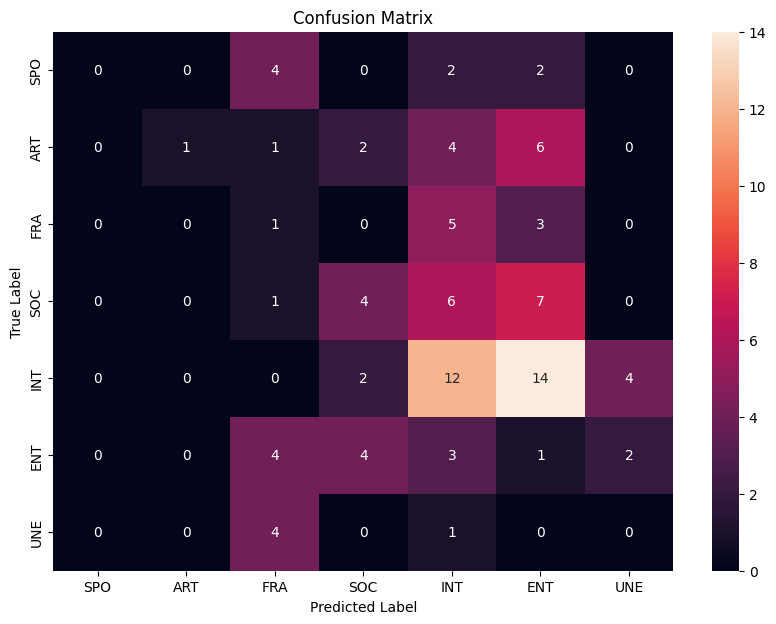

Total processing time for 100 articles: 33.41 seconds
Average processing time per article: 0.33 seconds


In [8]:
labels = df["category"].unique().tolist()

num_articles = 100
df_sample = df.sample(n=num_articles, random_state=42)
articles = df_sample["text"].str[:500].tolist()
true_labels = df_sample["category"].tolist()

### classification
predictions = []
processing_times = []

for text in tqdm(articles):
    start_time = time.time()
    result = classifier(text, labels)
    processing_times.append(time.time() - start_time)
    predictions.append(result["labels"][0])

### evaluation metrics
accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_report(true_labels, predictions))

### confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions, labels=labels)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

### results
total_time = sum(processing_times)
avg_time = total_time / num_articles
print(f"Total processing time for {num_articles} articles: {total_time:.2f} seconds")
print(f"Average processing time per article: {avg_time:.2f} seconds")

In [11]:
model = AutoModel.from_pretrained(MODEL_NAME)
model_size = sum(p.numel() for p in model.parameters()) * 4 / (1024**2)  # Size in MB
print(f"Model size: {model_size:.2f} MB")

Model size: 1549.88 MB


The performances are not that good, both recall and precision are not satisfactory.